# First Order Signal

In [1]:
from IPython import display
from ekfNN.generate import first_order_signal
from ekfNN.initialize_mlp import TanhMLP
from ekfNN.utilities import get_nn_weights, get_nn_weights_grad, set_nn_weights
from ekfNN.utilities import error_metrics, plot_results

from torch import mm

import torch
import torch.nn as nn

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("tableau-colorblind10")
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 

torch.set_default_dtype(torch.float64)
device = "cpu"

In [2]:
help(first_order_signal)

Help on function first_order_signal in module ekfNN.generate:

first_order_signal(N=100, noise=0.15, Kp=3, Tp=2, random_state=0, plot=False)
    Simulate a first order system (Tp * dy/dt = -y + K*u) 
    with an accompanying plot.
    
        State Space Model: 
            X_dot = Ax + Bu
                y = Cx + Du
    
            Where:
            A = 1 / Tp, B = Kp / Tp
            C = 1,      D = 0     
        
        Differential Equation: dy/dt = -(1/Tp)y + (Kp/Tp)u
    
    Based on the implementation presented here:
    https://apmonitor.com/pdc/index.php/Main/ModelSimulation
    
    Parameters
    ----------
        N : int 
            The no. of data points to generate
        noise : float
            The amount of measurement noise to apply
        random_state : int
            The seed value applied for 
    Outputs
    -------
        t_true : array
            Time index
        y_true : array
            True values of the signal
        y_meas : array
        

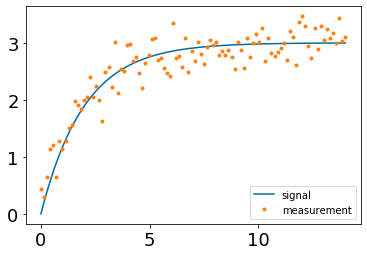

In [3]:
# Load data
x, y_true, y_meas = first_order_signal(N=100, Kp=3, Tp=2, noise=0.25, 
                                       random_state=0, plot=True)

x_train = torch.tensor(x, device=device, dtype=torch.float64)
y_train = torch.tensor(y_meas, device=device, dtype=torch.float64)

# Feedforward Neural Network (Training Step)

In [4]:
n_inputs, n_hidden_nodes, n_outputs = (1, 10, 1)

# Initialize the network
mlp_tanh_20 = TanhMLP(n_inputs, n_hidden_nodes, n_outputs, bias=True).to(device)
print(mlp_tanh_20)

# Set optimization algorithm; alternative could be SGD
optimizer = torch.optim.SGD(mlp_tanh_20.parameters(), lr=0.05)
# Set the loss function
mse = nn.MSELoss()

# Training in 15 iterations
n_epochs = 20
for epoch in range(n_epochs):
    # clear old gradients from last step
    mlp_tanh_20.zero_grad()
    # forward pass
    outputs = mlp_tanh_20(x_train)
    loss = mse(outputs, y_train)
    # compute dloss/dx for weights (parameters)
    loss.backward() 
    # update the weights (parameters of the NN)
    optimizer.step()

TanhMLP(
  (layer1): Linear(in_features=1, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)


## Feedforward NN Model Evaluation 

### Training Set Results 

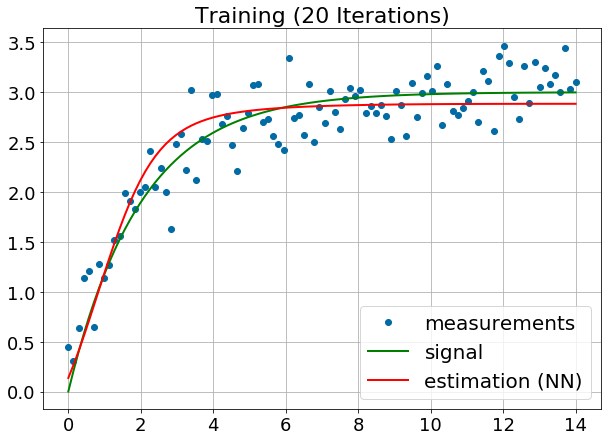

In [5]:
# Plot training results
mlp_tanh_20_preds = mlp_tanh_20(x_train).detach().numpy()

plot_results(x, y_true, y_meas, y_preds=mlp_tanh_20_preds, 
             title=f"Training ({n_epochs} Iterations)", save_loc="./images/first_order_train_nn.pdf")

In [6]:
# RMSE and MAE training error metrics
print("Training Error:")
train_rmse, train_mae = error_metrics(y_true, mlp_tanh_20_preds, show=True)

Training Error:
RMSE: 0.1227
MAE:  0.1041


In [7]:
# The following function is to measure the training time.
def train_mlp_tanh_20():
    n_inputs, n_hidden_nodes, n_outputs = (1, 10, 1)

    # Initialize the network
    mlp_tanh_20 = TanhMLP(n_inputs, n_hidden_nodes, n_outputs, bias=True).to(device)
    # Set optimization algorithm; alternative could be SGD
    optimizer = torch.optim.SGD(mlp_tanh_20.parameters(), lr=0.05)
    # Set the loss function
    mse = nn.MSELoss()

    # Training in 15 iterations
    n_epochs = 20
    for epoch in range(n_epochs):
        # clear old gradients from last step
        mlp_tanh_20.zero_grad()
        # forward pass
        outputs = mlp_tanh_20(x_train)
        loss = mse(outputs, y_train)
        # compute dloss/dx for weights (parameters)
        loss.backward() 
        # update the weights (parameters of the NN)
        optimizer.step()

# estimation of training time (cell below)

In [8]:
%%timeit
train_mlp_tanh_20()

16.7 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Test Set Results 

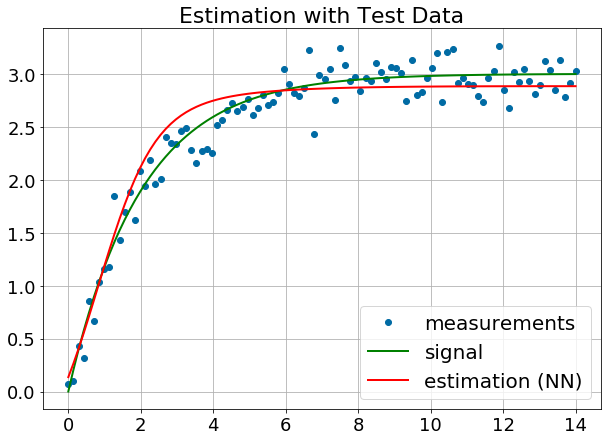

In [9]:
# Test data 
# (set a different random_state to maintain independence from training data)
x_test, y_test, y_meas_test = first_order_signal(Kp=3, Tp=2, random_state=12)
x_pred = torch.tensor(x_test, device=device, dtype=torch.float64)

# Make prediction & store prediction as numpy array
y_pred = mlp_tanh_20(x_pred).detach().numpy()

# Visual results for test data
plot_results(x=x_test, y_true=y_test, y_meas=y_meas_test, y_preds=y_pred, 
             title="Estimation with Test Data", save_loc="./images/first_order_test_nn.pdf")

In [10]:
# RMSE and MAE test error metrics
print("Test Error:")
test_rmse, test_mae = error_metrics(y_true, y_pred, show=True)

Test Error:
RMSE: 0.1227
MAE:  0.1041


In [11]:
# estimation of training time (cell below)

In [12]:
%%timeit
mlp_tanh_20(x_pred)

255 µs ± 6.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# EKF aided Neural Network (Training Step)

In [13]:
# Initialize NN

n_inputs, n_hidden_nodes, n_outputs = (1, 10, 1)

mlp_ekf = TanhMLP(n_inputs, n_hidden_nodes, n_outputs, bias=False)
mlp_ekf = mlp_ekf.to(device)
mse = nn.MSELoss(reduction=None)
weights = get_nn_weights(mlp_ekf)


# Set EKF Noises and Covariances

# P = Covariance Matrix
P = 1000 * torch.eye(weights.shape[0], 
                     device=device, dtype=torch.float64)

# Q = System Noise
Q = 1e-8 * torch.eye(weights.shape[0], 
                     device=device, dtype=torch.float64)

# R = Measurement Noise
R = 100 * torch.eye(n_inputs, 
                    device=device, dtype=torch.float64)


print(mlp_ekf)

TanhMLP(
  (layer1): Linear(in_features=1, out_features=10, bias=False)
  (layer2): Linear(in_features=10, out_features=10, bias=False)
  (layer3): Linear(in_features=10, out_features=1, bias=False)
)


In [14]:
# EKF+NN Training

n_epochs = 20

for epoch in range(n_epochs):    
    outputs = []
    for i in range(x_train.shape[0]):
        
        # Predict state estimate
        output = mlp_ekf(x_train[i]) 

        outputs.append(output)
        mlp_ekf.zero_grad()
        output.backward(torch.ones_like(output))
        
        # Jacobian
        H = get_nn_weights_grad(mlp_ekf).to(device).view(1, -1)
        
        # Calculate Kalman Gain
        intermediate = mm(mm(H, P), torch.transpose(H, 0, 1))
        intermediate = torch.inverse(R + intermediate)
        Kk = mm(mm(P, torch.transpose(H, 0, 1)), intermediate)

        # Update state estimate
        loss = (y_train[i, -1] - output).view(1, 1)
        weights = get_nn_weights(mlp_ekf) + mm(Kk, loss)
        
        # Pass on the new weights to NN
        set_nn_weights(mlp_ekf, weights)
        
        # Update error covariance error covariance for next iteration of EKF
        P = P + Q - mm(mm(Kk, H), P)

    outputs = torch.cat(outputs, dim=0)

## EKF+NN Model Evaluation 

### Training Set Results

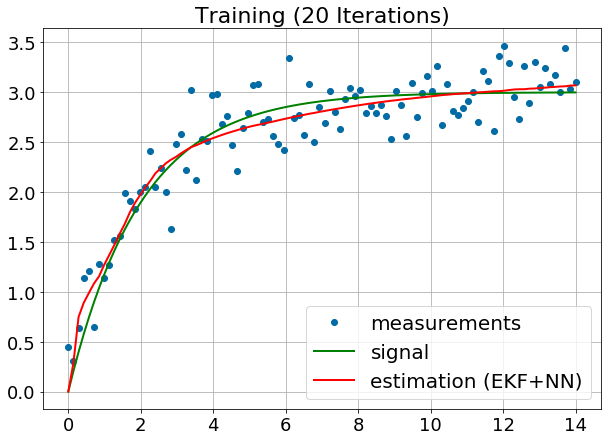

In [15]:
# Plot training results
plot_results(x, y_true, y_meas, y_preds=outputs.detach().numpy(), 
             title=f"Training ({n_epochs} Iterations)", ekf=True, save_loc="./images/first_order_train_ekfnn.pdf")

In [16]:
# RMSE and MAE training error metrics
print("Training Error:")
train_rmse, train_mae = error_metrics(y_true, outputs.detach().numpy(), show=True)

Training Error:
RMSE: 0.0885
MAE:  0.0686


In [17]:
# The following function is to measure the training time.
# However, the function does not only contain the "training" aspect
# of EKF based neural network, but also the initialization of the
# network and the noises and covariances for EKF
def train_mlp_ekf():
    n_inputs, n_hidden_nodes, n_outputs = (1, 10, 1)
    mlp_ekf = TanhMLP(n_inputs, n_hidden_nodes, n_outputs, bias=False)
    mlp_ekf = mlp_ekf.to(device)
    mse = nn.MSELoss(reduction=None)
    weights = get_nn_weights(mlp_ekf)
    Q = 1e-8 * torch.eye(weights.shape[0], 
                         device=device, dtype=torch.float64)
    R = 100 * torch.eye(n_inputs, 
                        device=device, dtype=torch.float64)
    P = 1000 * torch.eye(weights.shape[0], 
                         device=device, dtype=torch.float64)
    n_epochs = 20
    for epoch in range(n_epochs):
        outputs = []
        for i in range(x_train.shape[0]):
        output = mlp_ekf(x_train[i]) 
        outputs.append(output)
        mlp_ekf.zero_grad()
        output.backward(torch.ones_like(output))
        H = get_nn_weights_grad(mlp_ekf).to(device).view(1, -1)
        intermediate = mm(mm(H, P), torch.transpose(H, 0, 1))
        intermediate = torch.inverse(R + intermediate)
        Kk = mm(mm(P, torch.transpose(H, 0, 1)), intermediate)
        loss = (y_train[i, -1] - output).view(1, 1)
        weights = get_nn_weights(mlp_ekf) + mm(Kk, loss)
        set_nn_weights(mlp_ekf, weights)
        P = P + Q - mm(mm(Kk, H), P)
    outputs = torch.cat(outputs, dim=0)
        
# estimation of training time (cell below)

In [18]:
%%timeit
train_mlp_ekf()

3.06 s ± 209 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Test Set Results 

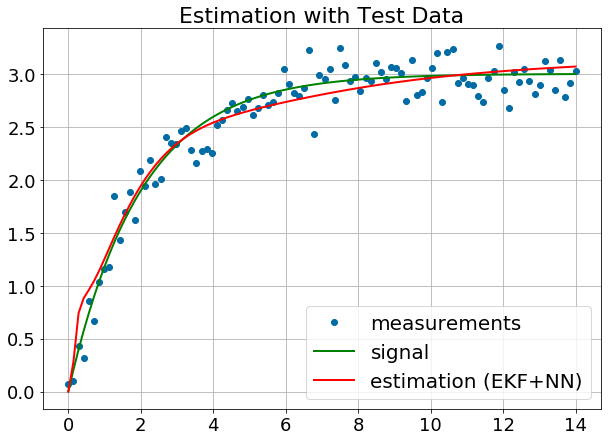

In [19]:
# Test data 
# (set a different random_state to maintain independence from training data)
x_test, y_test, y_meas_test = first_order_signal(Kp=3, Tp=2, random_state=12)
x_pred = torch.tensor(x_test, device=device, dtype=torch.float64)

# Make prediction & store prediction as numpy array
y_pred = mlp_ekf(x_pred).detach().numpy()

# Visual results for test data
plot_results(x=x_test, y_true=y_test, y_meas=y_meas_test, y_preds=y_pred, 
             title="Estimation with Test Data", ekf=True, save_loc="./images/first_order_test_ekfnn.pdf")

In [20]:
# Test error metrics
print("Test Error:")
test_rmse, test_mae = error_metrics(y_true, y_pred, show=True)

Test Error:
RMSE: 0.0844
MAE:  0.0651


In [21]:
# estimation of prediction time (cell below)

In [22]:
%%timeit
mlp_ekf(x_pred)

262 µs ± 6.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
